<a href="https://colab.research.google.com/github/ironcevic/modelling_week11/blob/main/Practical11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Welcome to Google Colab! (yes single l)
Colab is set up in Python.
In Colab, some lines are code and some are comments.
This whole block is a comment because it is encased in quotes.
Comments can also be marked with #.
You can toggle # on and off using "Ctrl + /".
"""

print("Hello, world!") # this is a line of code
# print("This is commented out") # this will not execute as it starts with #

a = 5
# a = "ice cream"
print(a) # is a 5 or ice cream?

"""
You can also run bash commands by pre-appending lines with "!".
Try it below.
There is also a file explorer on the left.
"""

!ls # this is a bash command
!pwd


Hello, world!
5
sample_data
/content


In [9]:
"""
Here we will install Quantum Espresso and load the modules we need.
"""

!sudo apt-get update
!sudo apt-get install -y quantum-espresso
!pip install ase
!git clone https://github.com/ironcevic/modelling_week11.git
!mv modelling_week11/* .
!rm -r modelling_week11
from functions import *


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [10]:
"""
We can inspect our first input file, cumulene.scf.in, by double-clicking on it.
We can write the geometry to a different file in order to visualise it.
This is done by creating a python object, atoms, and writing it to a file.
After executing the code below, open "unitcell.xsf" using Vesta
and "supercell.xyz" using Avogadro.
"""

atoms = read('cumulene.scf.in', format='espresso-in') # load geometry
write('unitcell.xsf', atoms) # write the atoms object as an xsf
supercell = atoms.repeat((10, 1, 1)) # create supercell object
write('supercell.xyz', supercell) # write supercell object as xyz



In [11]:
"""
Let's run our first Quantum Espresso calculation.
This will take ~1 min 50 s.
What does it generate?
"""

!pw.x < cumulene.scf.in > cumulene.scf.out


In [12]:
"""
Now we shall run a density of states (DOS) post-processing calculation.
Which files does it produce?
"""

!dos.x < cumulene.dos.in > cumulene.dos.out


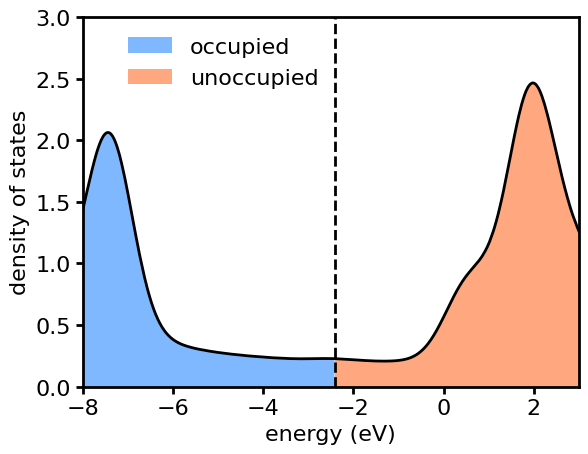

In [15]:
"""
To analyse the results of our DOS calculation, we shall load the results from
cumulene.dos into an object called dos. Then we plot the density of states.
"""

dos = np.genfromtxt("cumulene.dos", skip_header=1) # create the dos object

# print(dos[0]) # what does this print?
# print(dos.T[0]) # how about this?

fermi_level = -2.4177 # find in the scf output
energy_limits = [-8, 3] # where do we plot the energy

# this below prints the DOS
plt.plot(dos[:, 0], dos[:, 1], color = 'k') # plot the dos as a black line
plt.axvline(fermi_level, linestyle='dashed', color = "k") # fermi energy
# the next two lines make a fill with a colour depending on occupancy
plt.fill_between(dos[:, 0], dos[:, 1], where=(dos[:, 0] < fermi_level),
                 facecolor=colours["blue"], alpha=0.5, label='occupied')
plt.fill_between(dos[:, 0], dos[:, 1], where=(dos[:, 0] >= fermi_level),
                 facecolor=colours["orange"], alpha=0.5, label='unoccupied')
plt.xlabel("energy (eV)")
plt.ylabel("density of states")
plt.xlim(energy_limits)
plt.ylim(0, 3)
plt.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.05, 1))
plt.show()

In [16]:
"""
Let us now plot the band structure. First we run a post-processing calculation.
What does it generate?
"""

!bands.x < cumulene.bands.in > cumulene.bands.out


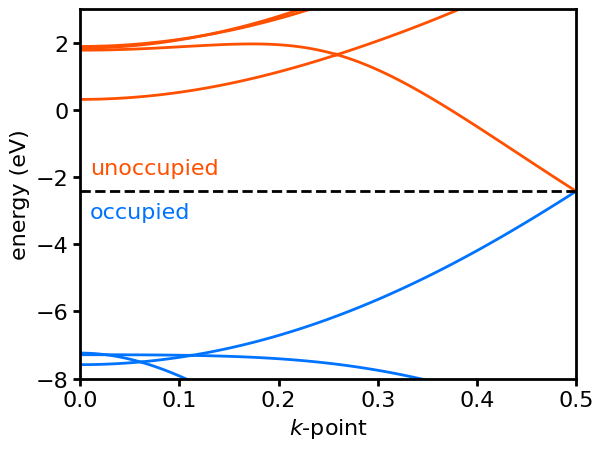

Valence band effective mass is 0.0155.
Conduction band effective mass is 0.0153.


In [17]:
"""
Let us now plot the band structure.
"""

bands = np.genfromtxt("cumulene.bands.dat.gnu") # create the bands object
# print(np.shape(bands)) # what is its shape? compare with the .gnu file
bands = np.split(bands, 9) # split it into 9 bands
# print(np.shape(bands)) # what is its shape now?
# print(bands[0]) # try printing the energies of the first band!

fermi_level = -2.4177 # find in the scf output
energy_limits = [-8, 3] # the energy range to plot

# here below we shall plot the band structure
for band in bands:
    x = band[:, 0]
    y = band[:, 1]
    # can you figure out what the four lines below do?
    if np.all(y < fermi_level):
        plt.plot(x, y, color=colours["blue"])
    else:
        plt.plot(x, y, color=colours["orange"])
plt.ylim(energy_limits)
plt.xlim(0, 0.5)
plt.axhline(y=fermi_level, color='k', linestyle='--')
plt.xlabel(r"$k$-point")
plt.ylabel("energy (eV)")
plt.annotate("occupied", xy=(0.01, fermi_level-0.8), color=colours["blue"])
plt.annotate("unoccupied", xy=(0.01, fermi_level+0.5), color=colours["orange"])
plt.show()

# Determine the effective masses.
mass_vb = effective_mass(bands[4][:, 0], bands[4][:, 1], a=2.46, n_points=5)
mass_cb = effective_mass(bands[5][:, 0], bands[5][:, 1], a=2.46, n_points=5)
print(f"Valence band effective mass is {np.abs(np.round(mass_vb, 4))}.")
print(f"Conduction band effective mass is {np.abs(np.round(mass_cb, 4))}.")


In [ ]:
"""
All these results were obtained for a cumulenic geometry.
Let's now relax the geometry and do it all again.
Inspect the input flags in polyene.relax.in.
What do you expect to get?
With a reasonable starting geometry this takes 4-5 min.
"""

!pw.x < polyene.relax.in > polyene.relax.out


In [ ]:
"""
Now paste the results into polyene.scf.in and visualise the optimised geometry.
Hint: you can just reuse the code from above.
"""



In [ ]:
"""
If you are happy with the geometry, paste it in polyene.scf.in and we can
proceed with the scf calculation. About 2 min.
"""

!pw.x < polyene.scf.in > polyene.scf.out


In [ ]:
"""
Now let's plot the density of states, band structure, and determine the band gap
and the effective masses. Try to do this on your own. You will need to make new
input files and reuse the code from above. Be careful to change the prefix.
"""

# !dos.x < polyene.dos.in > polyene.dos.out
# !bands.x < polyene.bands.in > polyene.bands.out

